# Stock Prediction using RNN
- 시가, 종가, 고가, 저가, 거래량을 이용하여 주가 예측
- RNN-LSTM 모델 활용

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time

/Users/junyoung/.pyenv/versions/python3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset (KAKAO 035720)
- **all** / 2000.09.01 ~ 2018.04.10
- **train** / 2010.01.01 ~ 2018.03.30
- **test** / 2018.03.30 ~ 2018.04.09
- **predict** / 2018.04.10

In [2]:
df = pd.read_pickle("../dataset/035720.p")[::-1]
df = df.drop(['diff'], axis=1)

# split train, test, predict dataset
train = df[df['date'].between('2010-01-01', '2018-03-30', inclusive=True)]
test = df[df['date'].between('2018-03-30', '2018-04-09', inclusive=True)]
predict = df[df['date'] == '2018-04-10']

# set index
train = train.set_index('date').sort_index()
test = test.set_index('date').sort_index()
predict = predict.set_index('date').sort_index()
train.head()

,close,open,high,low,volume
date,,,,,
2010-01-04,73400.0,70300.0,74200.0,69100.0,158976.0
2010-01-05,74000.0,73000.0,75300.0,72200.0,124156.0
2010-01-06,74300.0,74600.0,75200.0,73000.0,72453.0
2010-01-07,73400.0,74300.0,74800.0,72100.0,99241.0
2010-01-08,72900.0,73500.0,73500.0,70100.0,114818.0


## Preprocessing

In [3]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# Normalize Open, High, Low, Volume, Close
timesteps = seq_length = 7
xy = train.as_matrix()

# Open, High, Low, Volume, Close
test_min = np.min(xy,0)
test_max = np.max(xy,0)
denom = test_max - test_min

xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-2]]  # Close as label

test_last_X = test.as_matrix().reshape(1,7,5);
test_last_min = np.min(test_last_X, 0)
test_last_max = np.max(test_last_X, 0)
test_last_denom = test_last_max - test_last_min

# real Prediction data
real_stock = predict.as_matrix()

# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
   # print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split 7/3
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

## Training

In [4]:
# train Parameters
tf.set_random_seed(777)  # reproducibility
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate=0.01
iterations=200

# start time setting
startTime = time.time()

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='input_X')
Y = tf.placeholder(tf.float32, [None, 1], name='intput_Y')

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y), name='losses_sum')  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss, name='train')

# RMSE
targets = tf.placeholder(tf.float32, [None, 1], name='targets')
predictions = tf.placeholder(tf.float32, [None, 1], name='predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)), name='rmse')

# Running
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Tensorboard
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)

    losslist = [];    
    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))
        losslist = np.append(losslist, step_loss)

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse))

    # Print train_size, test_size
    print("train_size : {}".format(train_size))
    print("test_size : {}".format(test_size))

    # Predictions test
    prediction_test = sess.run(Y_pred, feed_dict={X: test_last_X})
    print("real stock price : ", end='')
    real_value = real_stock[0][-2] 
    print(real_value)

    print("prediction stock price : ", end='')
    prediction_value = (prediction_test*test_last_denom + test_last_min)[-1][-2]
    print(prediction_value)

    print("Error rate : ", end='')
    print(abs(prediction_value - real_value)/prediction_value * 100)

elapsedTime = time.time() - startTime
print("it took " + "%.3f"%(elapsedTime) + " s.")

Instructions for updating:
Use the retry module or similar alternatives.
[step: 0] loss: 1209.452392578125
[step: 1] loss: 868.4657592773438
[step: 2] loss: 608.9510498046875
[step: 3] loss: 406.85015869140625
[step: 4] loss: 251.7310333251953
[step: 5] loss: 137.09107971191406
[step: 6] loss: 59.521087646484375
[step: 7] loss: 17.71158790588379
[step: 8] loss: 9.778762817382812
[step: 9] loss: 28.49774742126465
[step: 10] loss: 56.6303596496582
[step: 11] loss: 76.34831237792969
[step: 12] loss: 81.3844985961914
[step: 13] loss: 74.13064575195312
[step: 14] loss: 59.84622573852539
[step: 15] loss: 43.5367317199707
[step: 16] loss: 28.7889461517334
[step: 17] loss: 17.5892276763916
[step: 18] loss: 10.589344024658203
[step: 19] loss: 7.514991283416748
[step: 20] loss: 7.55174446105957
[step: 21] loss: 9.645807266235352
[step: 22] loss: 12.719586372375488
[step: 23] loss: 15.82641315460205
[step: 24] loss: 18.258943557739258
[step: 25] loss: 19.604143142700195
[step: 26] loss: 19.737436

## Result
- 200 step, learning_rate=0.01
- RMSE: 0.021403782069683075
- Error rate : 1.25

## Visualize result

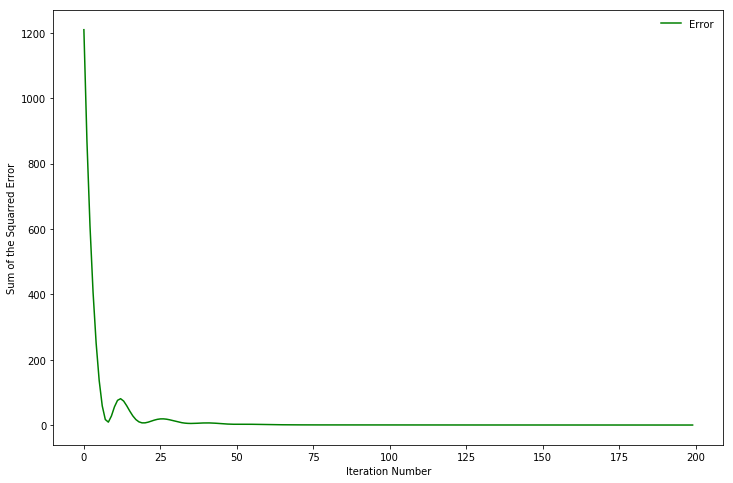

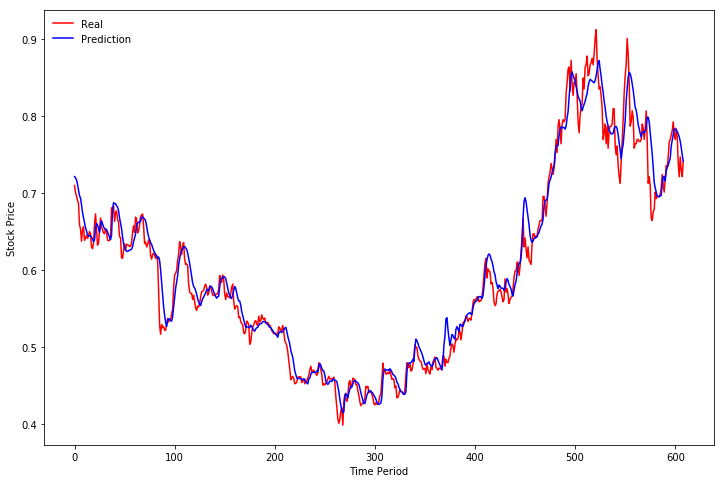

In [5]:
# Plot loss
plt.figure(figsize=(12,8))
plt.plot(losslist, color ="green", label ="Error");
plt.xlabel("Iteration Number")
plt.ylabel("Sum of the Squarred Error")
plt.legend(loc='upper right', frameon=False)

# Plot predictions
plt.figure(figsize=(12,8))
plt.plot(testY, color ="red", label ="Real")
plt.plot(test_predict, color ="blue", label ="Prediction")
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend(loc='upper left', frameon=False)
# plt.xticks([])
# plt.yticks([])
plt.show()

- timeseries gate에 따라 그냥 추세만 학습하는거 같음
- 현재 데이터와 가장 차이가 적은 값은 바로 직전 데이터
- 과거 시퀀스를 이용해 loss 값을 학습시키면 단순히 따라가는 예측 모델이 완성됨
- y = x-1 그래프와 유사할지도 모름
- 이 모델의 문제는 급등 / 급락을 잡기 힘들다는 것